In [1]:
# import modules
import geopandas as gpd
import matplotlib.pyplot as plt

In [4]:
#  file path
fp = "data/Corine2012_Uusimaa.shp"
# define GeoDataFrame
data = gpd.read_file(fp)
# print sample data
data.head()

,Level1,Level1Eng,Level1Suo,Level2,Level2Eng,Level2Suo,Level3,Level3Eng,Level3Suo,Luokka3,geometry
0,1,Artificial surfaces,Rakennetut alueet,11,Urban fabric,Asuinalueet,112,Discontinuous urban fabric,Väljästi rakennetut asuinalueet,112,"POLYGON ((279500.000 6640640.000, 279507.469 6..."
1,1,Artificial surfaces,Rakennetut alueet,11,Urban fabric,Asuinalueet,112,Discontinuous urban fabric,Väljästi rakennetut asuinalueet,112,"POLYGON ((313620.000 6655820.000, 313639.891 6..."
2,1,Artificial surfaces,Rakennetut alueet,11,Urban fabric,Asuinalueet,112,Discontinuous urban fabric,Väljästi rakennetut asuinalueet,112,"POLYGON ((399720.000 6680460.000, 399672.212 6..."
3,3,Forests and semi-natural areas,Metsät sekä avoimet kankaat ja kalliomaat,32,Shrub and/or herbaceous vegetation associations,Harvapuustoiset metsät ja pensastot,324,Transitional woodland/shrub,Harvapuustoiset alueet,324,"POLYGON ((469320.000 6718500.000, 469344.023 6..."
4,3,Forests and semi-natural areas,Metsät sekä avoimet kankaat ja kalliomaat,32,Shrub and/or herbaceous vegetation associations,Harvapuustoiset metsät ja pensastot,324,Transitional woodland/shrub,Harvapuustoiset alueet,324,"POLYGON ((403180.000 6718140.000, 403179.318 6..."


Select only English columns

In [10]:
# Select only English columns
selected_cols = ['Level1', 'Level1Eng', 'Level2', 'Level2Eng', 'Level3', 'Level3Eng', 'Luokka3', 'geometry']
# re-define GDF columns
data = data[selected_cols]

# print GDF columns 
data.columns

Index(['Level1', 'Level1Eng', 'Level2', 'Level2Eng', 'Level3', 'Level3Eng',
       'Luokka3', 'geometry'],
      dtype='object')

Let's plot the data using column 'level3' as our color

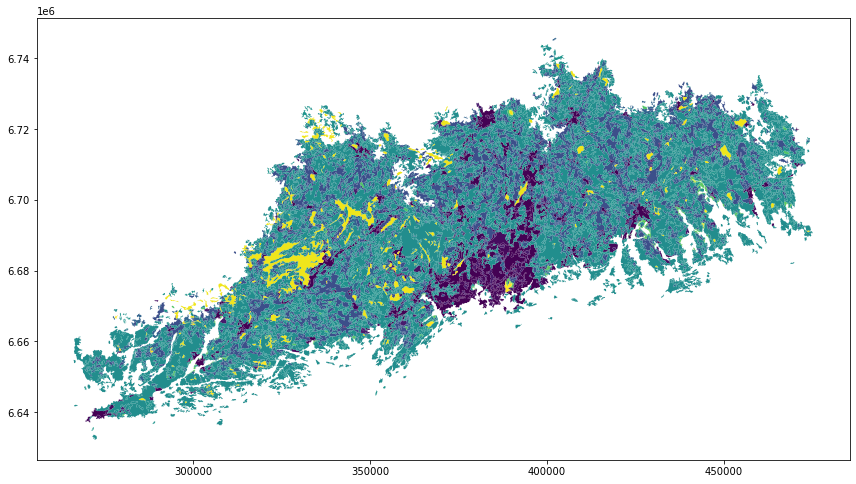

In [13]:
fig, ax = plt.subplots(figsize=(12, 10))

ax = ax
data.plot(ax = ax, column= 'Level3', linewidth= 0.5)

# Use tigh layout and remove empty whitespace aroynd our map
plt.tight_layout()

Print the values that are in the column 'Level3Eng'

In [14]:
list(data['Level3Eng'].unique())

['Discontinuous urban fabric',
 'Transitional woodland/shrub',
 'Non-irrigated arable land',
 'Fruit trees and berry plantations',
 'Pastures',
 'Land principally occupied by agriculture, with significant areas of natural vegetation',
 'Bare rock',
 'Inland marshes',
 'Peatbogs',
 'Salt marshes',
 'Water courses',
 'Water bodies',
 'Sea and ocean',
 'Industrial or commercial units',
 'Road and rail networks and associated land',
 'Port areas',
 'Airports',
 'Mineral extraction sites',
 'Broad-leaved forest',
 'Dump sites',
 'Coniferous forest',
 'Construction sites',
 'Green urban areas',
 'Sport and leisure facilities',
 'Mixed forest']

Now that we know that we know what type of landcover we have, let's select one of them `'Water bodies'` from our data 

In [16]:
# Select Water bodies and make a copy of the GeoDataFrame
lakes = data.loc[data['Level3Eng'] == 'Water bodies'].copy()

lakes.head(2)

,Level1,Level1Eng,Level2,Level2Eng,Level3,Level3Eng,Luokka3,geometry
1388,5,Water bodies,51,Inland waters,512,Water bodies,512,"POLYGON ((298388.189 6642944.190, 298364.453 6..."
1389,5,Water bodies,51,Inland waters,512,Water bodies,512,"POLYGON ((286629.258 6643429.219, 286668.535 6..."


Calculations in GeoDataFrame
<br>
Ok!, now that we have lakes as a GeoDataFrame, we need to classify the data into small lakes and big lakes based on average size of all lakes in our study area.Let's calculate the average lake's size

Let's check the coordinate system

In [22]:
### Import CRS class from pyproj
from pyproj import CRS

# Check coordinate system info
crs_proj4 = CRS(data.crs).to_proj4()

crs_proj4

C:\Users\gcolm\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  """


'+proj=utm +zone=35 +ellps=GRS80 +units=m +no_defs +type=crs'

Ok, this tells us that the units are in meters, and is in UTM projection
- Let's calculate the area of the lakes

In [25]:
# Calculating lakes areas
lakes['area'] = lakes.area

print(lakes['area'].head(2))

1388    268310.708164
1389    917661.921348
Name: area, dtype: float64


Notice that the value are now in square meters. Let's change that into square kilometers so they are easier to read

In [34]:
# convert  mtrs^2 into km^2
lakes['areas_km2'] = lakes.area / 1000000

# What is the mean size of our lakes?
l_mean_size = lakes['areas_km2'].mean()

# print the mean size
print(f"The average size of the lakes is: {round(l_mean_size, 2)} Km2")

The average size of the lakes is: 1.58 Km2


## Classifying Data
Creating custom classifier
<br>
Create a function where we classify the geometry of the lakes into two classes based on a given `threshold` - parameter. 
- Parameters: 
    - if area of polygon is lower than the threshold (avg size), the output column will get a value of 0
    - if it is larger, it will get value of 1. This kind of classification is called <i>Binary classification.</i>

In [35]:
# define function that takes a single row from the GeoDataFrame and some other parameters.

def binaryClassifier(row, source_col, output_col, threshold):
    # if area of input is lower than threshold
    if row[source_col] < threshold:
        # update output column with value 0
        row[output_col] = 0
    # if area of input geometry is higher than threshold
    else:
        # update output column with value 1
        row[source_col]= 1
        
    return row

In [38]:
# Create enpty column
lakes['small_big'] = None

# Apply custom function to the GeoDataFrame
lakes = lakes.apply(binaryClassifier, source_col= 'areas_km2', output_col= 'small_big', threshold= l_mean_size, axis=1)

lakes.head()

,Level1,Level1Eng,Level2,Level2Eng,Level3,Level3Eng,Luokka3,geometry,area,areas_km2,small_big
1388,5,Water bodies,51,Inland waters,512,Water bodies,512,"POLYGON ((298388.189 6642944.190, 298364.453 6...",268310.708164,0.268311,0
1389,5,Water bodies,51,Inland waters,512,Water bodies,512,"POLYGON ((286629.258 6643429.219, 286668.535 6...",917661.921348,0.917662,0
1390,5,Water bodies,51,Inland waters,512,Water bodies,512,"POLYGON ((300239.023 6649391.484, 300228.203 6...",272964.307429,0.272964,0
1391,5,Water bodies,51,Inland waters,512,Water bodies,512,"POLYGON ((300722.226 6650140.234, 300776.601 6...",351962.332987,0.351962,0
1392,5,Water bodies,51,Inland waters,512,Water bodies,512,"POLYGON ((312060.000 6651400.000, 312069.766 6...",739194.333134,0.739194,0


Now let's plot the lakes and see how they look like

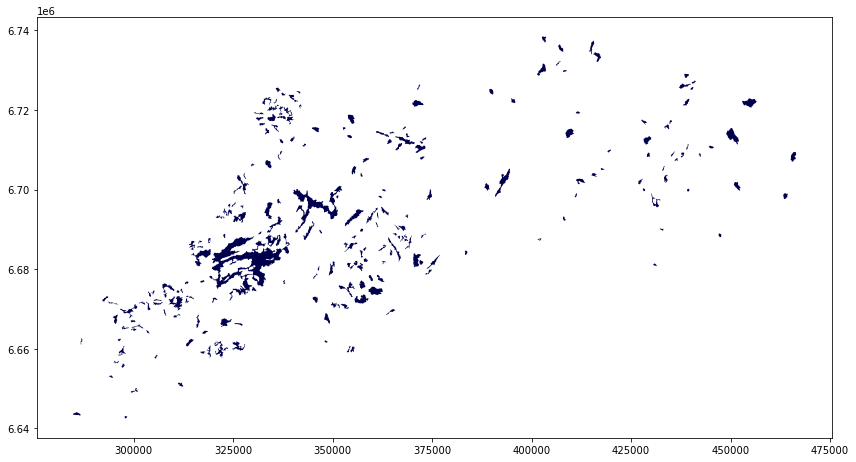

In [46]:
fig, ax = plt.subplots(figsize=(12, 10))
ax=ax
lakes.plot(ax= ax, column= 'small_big', linewidth= 0.05, cmap='seismic')

plt.tight_layout()

Save lakes GeoDataFrame as a Shapefile

In [47]:
# define location and name
output_lakes = r"data/lakes.shp"

# save file
lakes.to_file(output_lakes)